<a href="https://colab.research.google.com/github/proffranciscofernando/DataScience-PUCRio-MVP3/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Database Analysis of Wind Energy Data
## By Francisco Fernando Roberto Pereira
#### francisco.fernando@ufpe.br | franciscofernando1989@gmail.com

# 1. Problem Definition

## 1.1. Problem Background

In the wind energy sector, maximising energy production and ensuring efficient resource management are critical for sustainability and profitability. Wind turbines generate power based on various factors such as wind speed, direction, and environmental conditions. To optimise performance and identify potential improvements, a comprehensive analysis of historical wind turbine data is necessary.

## 1.2. Data Description

The dataset used in this project will be the **Wind Turbine SCADA** obtained from the SCADA system (*Supervisory Control and Data Acquisition*) of a wind turbine from a wind farm in Turkey during the year 2018.

The data on the attributes were acquired by the wind turbine's SCADA system in 10-minute intervals throughout the year 2018. The description of the attributes is as follows:
1. **Date/Time** - Date (in DD MM YYYY format) and time at 10-minute intervals;
2. **LV Active Power (kW)** - Power produced by the wind turbine at a given moment;
3. **Wind Speed (m/s)** - Wind speed at the hub height of the wind turbine (speed used for electricity generation);
4. **Theoretical Power Curve (kWh)** - Theoretical power values (provided by the manufacturer) that the wind turbine produces at a given wind speed;
5. **Wind Direction (°)** - Wind direction at the hub height of the wind turbine (wind turbines automatically position themselves to this direction);

For more details on this dataset, refer to: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

The impact of other environmental variables (such as temperature, atmospheric pressure, humidity, etc.) on wind energy production will not be considered in the future model. This is a limitation of this dataset, which does not include these variables.

This notebook was built and run on Databricks Community Edition.

## 1.3. Project's Goal

This project aims to provide a comprehensive understanding of the factors influencing wind turbine energy production, thus aiding in the optimisation of turbine operations and enhancing energy efficiency. To achieve this goal, the project will address the following questions:
1. What is the total energy production of the wind turbine in 2018?
2. What is the average energy production of the wind turbine per month?
3. What is the correlation between wind speed and energy production?
4. What is the difference between actual energy production and the theoretical power provided by the manufacturer?
5. How does wind direction affect energy production?
6. What are the patterns of energy production throughout the day?



## 1.4. Libraries

This is where we store all libraries used in this project.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, to_timestamp, year, month, dayofmonth, hour, dayofweek
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 2. Extraction and Transformation

Firstly, a SparkSession will be created and used. This ensures that you have a unified entry point for all Spark operations and simplifies the management of your Spark application.

Secondly, the raw data will be loaded using Spark DataFrame and the columns will be renamed.

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.appName("WindTurbineDataAnalysis").getOrCreate()

# Extraction: Load the raw data from the CSV file
file_path = 'dbfs:/FileStore/tables/wind_turbine_scada_data.csv'

# Load the raw data using a Spark DataFrame
df_raw = spark.read.csv(file_path, header=True, inferSchema=True)

# Rename the columns
df_renamed = df_raw.withColumnRenamed('LV ActivePower (kW)', 'active_power_kw') \
                   .withColumnRenamed('Theoretical_Power_Curve (KWh)', 'theoretical_power_kwh') \
                   .withColumnRenamed('Wind Speed (m/s)', 'wind_speed_mps') \
                   .withColumnRenamed('Wind Direction (°)', 'wind_direction_deg')

# Display the first few rows of the raw DataFrame
df_renamed.show(5)

+----------------+----------------+----------------+---------------------+------------------+
|       Date/Time| active_power_kw|  wind_speed_mps|theoretical_power_kwh|wind_direction_deg|
+----------------+----------------+----------------+---------------------+------------------+
|01 01 2018 00:00|380.047790527343|5.31133604049682|     416.328907824861|  259.994903564453|
|01 01 2018 00:10| 453.76919555664|5.67216682434082|     519.917511061494|   268.64111328125|
|01 01 2018 00:20|306.376586914062|5.21603679656982|     390.900015810951|  272.564788818359|
|01 01 2018 00:30|419.645904541015|5.65967416763305|     516.127568975674|  271.258087158203|
|01 01 2018 00:40|380.650695800781|5.57794094085693|     491.702971953588|  265.674285888671|
+----------------+----------------+----------------+---------------------+------------------+
only showing top 5 rows



Now let's get the number of rows and columns in a Spark DataFrame.

In [ ]:
# Get the number of rows
num_rows = df_renamed.count()

# Get the number of columns
num_columns = len(df_renamed.columns)

# Display the shape of the DataFrame
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 50530
Number of columns: 5


 It is a good practice to analyse the DataFrame to check if there are any null values and understand their distribution. This allows us to make informed decisions about how to handle them, if necessary.

In [ ]:
# Check for null values in each column
null_counts = df_renamed.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_renamed.columns])

# Display the count of null values in each column
null_counts.show()

+---------+---------------+--------------+---------------------+------------------+
|Date/Time|active_power_kw|wind_speed_mps|theoretical_power_kwh|wind_direction_deg|
+---------+---------------+--------------+---------------------+------------------+
|        0|              0|             0|                    0|                 0|
+---------+---------------+--------------+---------------------+------------------+



No null values were identified and no further action is required. Let's check for duplicates now.

In [ ]:
# Group by all columns and count occurrences
duplicates = df_renamed.groupBy(df_renamed.columns).count().filter("count > 1")

# Show the rows that are duplicates
duplicates.show()

+---------+---------------+--------------+---------------------+------------------+-----+
|Date/Time|active_power_kw|wind_speed_mps|theoretical_power_kwh|wind_direction_deg|count|
+---------+---------------+--------------+---------------------+------------------+-----+
+---------+---------------+--------------+---------------------+------------------+-----+



No duplicates were identified either.

Let's convert the data and time column to datatime format. This operation is important for performing time-based operations and analyses on the data, such as sorting by date, filtering by date range, and time series analysis.

In [ ]:
# Convert the 'Date/Time' column to timestamp format
df_transformed = df_renamed.withColumn('date_time_id', to_timestamp(col('Date/Time'), 'dd MM yyyy HH:mm'))

# Show the DataFrame to verify the transformation
df_transformed.show(5)

+----------------+----------------+----------------+---------------------+------------------+-------------------+
|       Date/Time| active_power_kw|  wind_speed_mps|theoretical_power_kwh|wind_direction_deg|       date_time_id|
+----------------+----------------+----------------+---------------------+------------------+-------------------+
|01 01 2018 00:00|380.047790527343|5.31133604049682|     416.328907824861|  259.994903564453|2018-01-01 00:00:00|
|01 01 2018 00:10| 453.76919555664|5.67216682434082|     519.917511061494|   268.64111328125|2018-01-01 00:10:00|
|01 01 2018 00:20|306.376586914062|5.21603679656982|     390.900015810951|  272.564788818359|2018-01-01 00:20:00|
|01 01 2018 00:30|419.645904541015|5.65967416763305|     516.127568975674|  271.258087158203|2018-01-01 00:30:00|
|01 01 2018 00:40|380.650695800781|5.57794094085693|     491.702971953588|  265.674285888671|2018-01-01 00:40:00|
+----------------+----------------+----------------+---------------------+--------------

Let's generate and display a comprehensive statistical summary of the DataFrame.

In [ ]:
# Display statistical summary of the cleaned data
df_transformed.describe().show()

+-------+----------------+------------------+-----------------+---------------------+------------------+
|summary|       Date/Time|   active_power_kw|   wind_speed_mps|theoretical_power_kwh|wind_direction_deg|
+-------+----------------+------------------+-----------------+---------------------+------------------+
|  count|           50530|             50530|            50530|                50530|             50530|
|   mean|            null|1307.6843318793121|7.557952236083209|   1492.1754629583377|123.68755850939199|
| stddev|            null|1312.4592421268117|4.227166055611553|   1368.0182378726681| 93.44373572772585|
|    min|01 01 2018 00:00| -2.47140502929687|              0.0|                  0.0|               0.0|
|    max|31 12 2018 23:50|  3618.73291015625| 25.2060108184814|               3600.0|  359.997589111328|
+-------+----------------+------------------+-----------------+---------------------+------------------+



# 3. Modelling


## 3.1. Star Schema

Here we will model the data in the star schema, which is ideal for this wind turbine energy production project due to its simplified and efficient data organisation. This structure enhances query performance and supports multi-dimensional analysis by separating granular measurements into a central fact table and contextual attributes into dimension tables.

The Time dimension in our star schema breaks down Date/Time into attributes like year, month, day, hour, day_of_week, and Weekend indicator. This enables comprehensive time-based analysis, allowing for efficient querying and aggregation over various periods. It supports granular insights from hourly assessments to yearly trends, aiding in the identification of patterns and informed decision-making.

In [ ]:
# Modelling: Structuring the data in a star schema

# Create the Time dimension
dim_time = df_transformed.select(
    col('date_time_id'),
    year(col('date_time_id')).alias('year'),
    month(col('date_time_id')).alias('month'),
    dayofmonth(col('date_time_id')).alias('day'),
    hour(col('date_time_id')).alias('hour'),
    dayofweek(col('date_time_id')).alias('day_of_week')
).withColumn('weekend', (dayofweek(col('date_time_id')).isin([1, 7])).cast('int'))

# Show the Time dimension DataFrame
dim_time.show(10)

+-------------------+----+-----+---+----+-----------+-------+
|       date_time_id|year|month|day|hour|day_of_week|weekend|
+-------------------+----+-----+---+----+-----------+-------+
|2018-01-01 00:00:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 00:10:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 00:20:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 00:30:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 00:40:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 00:50:00|2018|    1|  1|   0|          2|      0|
|2018-01-01 01:00:00|2018|    1|  1|   1|          2|      0|
|2018-01-01 01:10:00|2018|    1|  1|   1|          2|      0|
|2018-01-01 01:20:00|2018|    1|  1|   1|          2|      0|
|2018-01-01 01:30:00|2018|    1|  1|   1|          2|      0|
+-------------------+----+-----+---+----+-----------+-------+
only showing top 10 rows



On the other hand, the Meteorology dimension in our star schema captures key environmental factors, such as wind_speed and wind_direction, that influence wind turbine energy production. This dimension enables detailed analysis of how weather conditions affect energy output, facilitating the identification of optimal operating conditions and the impact of varying weather patterns. By structuring meteorological data into a dedicated dimension table, we ensure precise examination and correlation of environmental variables with energy production, leading to more accurate predictions and informed operational strategies.

In [ ]:
# Create the Meteorology dimension
dim_meteorology = df_transformed.select(
    col('date_time_id'),
    col('wind_speed_mps'),
    col('wind_direction_deg')
)

# Show the Meteorology dimension DataFrame
dim_meteorology.show(10)

+-------------------+----------------+------------------+
|       date_time_id|  wind_speed_mps|wind_direction_deg|
+-------------------+----------------+------------------+
|2018-01-01 00:00:00|5.31133604049682|  259.994903564453|
|2018-01-01 00:10:00|5.67216682434082|   268.64111328125|
|2018-01-01 00:20:00|5.21603679656982|  272.564788818359|
|2018-01-01 00:30:00|5.65967416763305|  271.258087158203|
|2018-01-01 00:40:00|5.57794094085693|  265.674285888671|
|2018-01-01 00:50:00|5.60405206680297|   264.57861328125|
|2018-01-01 01:00:00|5.79300785064697|  266.163604736328|
|2018-01-01 01:10:00|5.30604982376098|  257.949493408203|
|2018-01-01 01:20:00|5.58462905883789|  253.480697631835|
|2018-01-01 01:30:00|5.52322816848754|   258.72378540039|
+-------------------+----------------+------------------+
only showing top 10 rows



Now we will create the Fact Table for this wind turbine energy production project. This is designed to store the key performance metrics of the wind turbine, including Active Power and Theoretical Power. It also includes date_time_id, which serves as a foreign key to link with the Time dimension, and meteorological data like Wind Speed and Wind Direction which are part of the Meteorology dimension. This structure allows for detailed analysis of how different factors, such as time and weather conditions, impact the turbine's energy production. By organizing the data in this way, the Fact Table supports efficient querying and aggregation, facilitating comprehensive insights into the operational performance and efficiency of the wind turbine.

In [ ]:
# Create the Fact Table
fact_table = df_transformed.select(
    col('date_time_id'),
    col('active_power_kw'),
    col('theoretical_power_kwh'),
    col('wind_speed_mps'),
    col('wind_direction_deg')
)

# Show the Fact Table DataFrame
fact_table.show(10)

+-------------------+----------------+---------------------+----------------+------------------+
|       date_time_id| active_power_kw|theoretical_power_kwh|  wind_speed_mps|wind_direction_deg|
+-------------------+----------------+---------------------+----------------+------------------+
|2018-01-01 00:00:00|380.047790527343|     416.328907824861|5.31133604049682|  259.994903564453|
|2018-01-01 00:10:00| 453.76919555664|     519.917511061494|5.67216682434082|   268.64111328125|
|2018-01-01 00:20:00|306.376586914062|     390.900015810951|5.21603679656982|  272.564788818359|
|2018-01-01 00:30:00|419.645904541015|     516.127568975674|5.65967416763305|  271.258087158203|
|2018-01-01 00:40:00|380.650695800781|     491.702971953588|5.57794094085693|  265.674285888671|
|2018-01-01 00:50:00|402.391998291015|     499.436385024805|5.60405206680297|   264.57861328125|
|2018-01-01 01:00:00|447.605712890625|     557.372363290225|5.79300785064697|  266.163604736328|
|2018-01-01 01:10:00|     387.

The modelling phase was crucial as it structured the data into a star schema, enabling efficient analysis and reporting. By creating the Time and Meteorology dimensions, we provided context to the raw data, allowing for detailed insights into how temporal and environmental factors affect wind turbine performance. This organized approach ensures data consistency, reduces redundancy, and enhances the project's analytical capabilities, leading to more informed decision-making and optimization of energy production.

# 4. Delta Lake

## 4.1. Saving Data to Delta Tables

At this point, we will persist the structured data into a Delta Lake, which combines the benefits of data lakes and data warehouses by providing robust data storage with ACID transactions, scalability, and efficient query performance. Both Time and Meteorology dimensions will be saved to Delta tables, as well as the fact table. This ensures that the data is stored in a reliable and consistent manner. This persistence allows for efficient retrieval and analysis, supports updates and modifications, and ensures that the data can be integrated seamlessly into analytical workflows.

In [ ]:
# Save the Time dimension to a Delta table
dim_time.write.format("delta").mode("overwrite").save("/mnt/delta/dim_time")

# Save the Meteorology dimension to a Delta table
dim_meteorology.write.format("delta").mode("overwrite").save("/mnt/delta/dim_meteorology")

# Save the Fact Table to a Delta table
fact_table.write.format("delta").mode("overwrite").save("/mnt/delta/fact_energy_production")

In [ ]:
# Display the DataFrame using Databricks built-in visualization
fact_table.show(10)

+-------------------+----------------+---------------------+----------------+------------------+
|       date_time_id| active_power_kw|theoretical_power_kwh|  wind_speed_mps|wind_direction_deg|
+-------------------+----------------+---------------------+----------------+------------------+
|2018-01-01 00:00:00|380.047790527343|     416.328907824861|5.31133604049682|  259.994903564453|
|2018-01-01 00:10:00| 453.76919555664|     519.917511061494|5.67216682434082|   268.64111328125|
|2018-01-01 00:20:00|306.376586914062|     390.900015810951|5.21603679656982|  272.564788818359|
|2018-01-01 00:30:00|419.645904541015|     516.127568975674|5.65967416763305|  271.258087158203|
|2018-01-01 00:40:00|380.650695800781|     491.702971953588|5.57794094085693|  265.674285888671|
|2018-01-01 00:50:00|402.391998291015|     499.436385024805|5.60405206680297|   264.57861328125|
|2018-01-01 01:00:00|447.605712890625|     557.372363290225|5.79300785064697|  266.163604736328|
|2018-01-01 01:10:00|     387.

In [ ]:
# Summary for Fact Table
fact_table.describe().show()

+-------+------------------+---------------------+-----------------+------------------+
|summary|   active_power_kw|theoretical_power_kwh|   wind_speed_mps|wind_direction_deg|
+-------+------------------+---------------------+-----------------+------------------+
|  count|             50530|                50530|            50530|             50530|
|   mean|1307.6843318793121|   1492.1754629583377|7.557952236083209|123.68755850939199|
| stddev|1312.4592421268117|   1368.0182378726681|4.227166055611553| 93.44373572772585|
|    min| -2.47140502929687|                  0.0|              0.0|               0.0|
|    max|  3618.73291015625|               3600.0| 25.2060108184814|  359.997589111328|
+-------+------------------+---------------------+-----------------+------------------+



This table will be particularly useful to build the Data Catalog in the following section.

## 4.2. Data Catalog

**Data Lineage**

- **Source**: The dataset is obtained from the SCADA system of a wind turbine in a wind farm in Turkey during the year 2018.
- **Transformation**:
  - **Date/Time Conversion**: Converted the `Date/Time` column to a timestamp format.
  - **Dimension Creation**: Extracted relevant components to create Time and Meteorology dimensions.
  - **Fact Table Formation**: Combined key performance metrics and foreign keys to create the fact table.

**Summary**

This data catalog provides a comprehensive description of the fact and dimension tables, including the data types, expected ranges, and descriptions of each column. It also outlines the data lineage, ensuring transparency in the data transformation process.

**Fact Table: Energy Production**

| Column Name            | Data Type   | Description                                               |
|------------------------|-------------|-----------------------------------------------------------|
| date_time_id           | Timestamp   | Foreign key to the Time dimension, represents the date and time of the record. |
| active_power_kw        | Double      | Actual power (kW) produced by the wind turbine.                |
| theoretical_power_kwh  | Double      | Theoretical power (kWh) the turbine should produce at a given wind speed, according to the manufacturer. |
| wind_speed_mps          | Double      | Wind speed (m/s) at the hub height of the wind turbine.         |
| wind_direction_deg     | Double      | Wind direction (º) at the hub height of the wind turbine.     |

**Dimension Table: Time**

| Column Name    | Data Type | Description                                               |
|----------------|-----------|-----------------------------------------------------------|
| date_time_id   | Timestamp | Primary key, represents the date and time of the record.  |
| year           | Integer   | Year extracted from the date_time_id.                     |
| month          | Integer   | Month extracted from the date_time_id.                    |
| day            | Integer   | Day of the month extracted from the date_time_id.         |
| hour           | Integer   | Hour extracted from the date_time_id.                     |
| day_of_week    | Integer   | Day of the week extracted from the date_time_id (1=Monday, 7=Sunday). |
| weekend        | Integer   | Indicates if the day is a weekend (1 for Saturday and Sunday, 0 otherwise). |

**Dimension Table: Meteorology**

| Column Name            | Data Type   | Description                                               |
|------------------------|-------------|-----------------------------------------------------------|
| date_time_id           | Timestamp   | Foreign key to the Time dimension, represents the date and time of the record. |
| wind_speed_mps          | Double      | Wind speed at the hub height of the wind turbine.         |
| wind_direction_deg     | Double      | Wind direction at the hub height of the wind turbine.     |

**Data Ranges and Expected Values**

**Fact Table: Energy Production**

| Column Name            | Min Value | Max Value |
|------------------------|-----------|-----------|
| active_power_kw        | -2.47         | 3618.73      |
| theoretical_power_kwh  | 0         | 3600     |
| wind_speed_mps          | 0         | 25.21       |
| wind_direction_deg     | 0         | 359.98       |

**Dimension Table: Time**

| Column Name    | Min Value | Max Value |
|----------------|-----------|-----------|
| year           | 2018      | 2018      |
| month          | 1         | 12        |
| day            | 1         | 31        |
| hour           | 0         | 23        |
| day_of_week    | 1         | 7         |
| weekend        | 0         | 1         |

**Dimension Table: Meteorology**

| Column Name            | Min Value | Max Value |
|------------------------|-----------|-----------|
| wind_speed_mps          | 0         | 25.21       |
| wind_direction_deg     | 0         | 359.98       |


# 5. Data Analysis

## 5.1. Data Quality

At this point, we can visualise the power curves of the wind turbine (Active Power vs. Wind Speed and Theoretical Power vs. Wind Speed). For a more effective comparison, we will plot these curve in the same graph, as shown bellow.

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame
fact_table_pd = fact_table.toPandas()

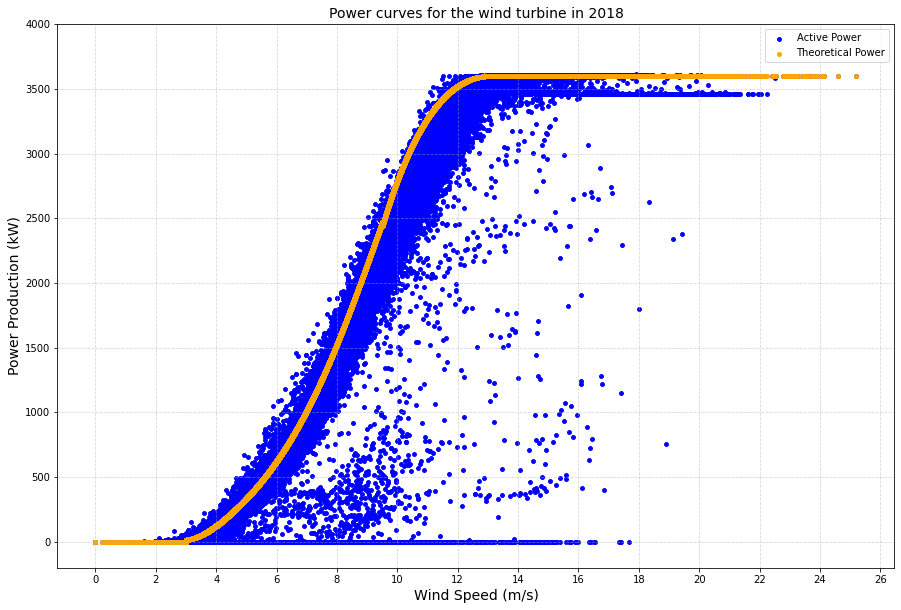

In [ ]:
# Plot power curves for the wind turbine

# Prepare the figure
plt.figure(figsize=(15, 10))

# Active power
plt.scatter(fact_table_pd['wind_speed_mps'], fact_table_pd['active_power_kw'], label='Active Power', color='blue', marker="o", s=15)

# Theoretical power
plt.scatter(fact_table_pd['wind_speed_mps'], fact_table_pd['theoretical_power_kwh'], label='Theoretical Power', color='orange', marker="o", s=15)

# Display legend
plt.legend()

# Label the x and y axes
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power Production (kW)', fontsize=14)
plt.title('Power curves for the wind turbine in 2018', fontsize=14)

# Explicitly set the x-axis limits
xmin = 0  # Specify the lower limit
xmax = 26  # Specify the upper limit
x_step = 2  # Specify the step
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10)  # Set step and font size of x-axis ticks

# Set the y-axis limits and step
ymin = 0  # Specify the lower limit
ymax = 4000  # Specify the upper limit
y_step = 500  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin-200, ymax)

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.5)

# Display the graph
plt.show()

By analyzing theses curves, we can see that active power has a large number of outliers compared to theoretical power. This has to be properly addressed before the data analysis, otherwise they will greatly impact the answers to the project questions.

The three sources of outlier values considered in this project are as follows:

**1. Negative or near-zero Active Power values:**
 * Description: power values tend to zero when wind speed is above the cut-in speed and below the cut-out speed.
 * Possible causes: wind turbine maintenance and wind limitation.

**2. Active Power Values far from the prediction in the Theoretical Power Curve:**
 * Description: active power values are significantly far from the expected values as represented by the theoretical power curve but are not zero.
 * Possible causes: wind limitation, dirt on the blades, insects or ice, pitch control malfunction, among other factors.

**3. Values that exceed the physical limitation of the equipment:**
 * Description: wind power reaches values that exceed the physical limitation of the wind turbine.
 * Possible causes: extreme operational conditions.

In the context, these outliers will have a significant impact on our data analysis. Thus, they need to be properly handled. This will be done by the following functions.

In [ ]:
# Function to remove outliers
def remove_outliers(df, column, min_percentile, max_percentile):
    """
    This function removes outliers from a specific column of the dataset
    using minimum and maximum percentiles.
    """
    # Calculate the quartiles for the minimum and maximum percentiles
    q_low = df[column].quantile(min_percentile)
    q_high = df[column].quantile(max_percentile)

    # Filter the DataFrame, keeping only the values within the quartile-defined range
    return df[(df[column] < q_high) & (df[column] > q_low)]

# Function to create data subsets
def create_data_subsets(data, step=50, upper_limit=3400):
    """
    This function divides the dataset into subsets based on the values of
    the 'active_power_kw' column. Each subset covers a specific range
    (defined by the step) and stores the subset in a dictionary. Each subset
    is represented by a lower limit, and the last subset includes values
    greater than or equal to 3300.
    """
    subsets = {}
    for lower_limit in range(20, upper_limit, step):
        upper_limit_current = lower_limit + step
        # Condition to create the subset based on the limits
        condition = (data['active_power_kw'] >= lower_limit) & (data['active_power_kw'] < upper_limit_current)
        subsets[lower_limit] = data[condition]

    # Add the last subset for values >= 3300
    subsets[upper_limit] = data[data['active_power_kw'] >= 3300]

    return subsets

# Create data subsets
data_subsets = create_data_subsets(fact_table_pd)

# List to hold the data subsets without outliers
filtered_data_subsets = []

for lower_limit, df in data_subsets.items():
    if lower_limit <= 3:
        F = 0.95
    elif 3 < lower_limit <= 10:
        F = 0.90
    elif 10 < lower_limit <= 20:
        F = 0.92
    elif 20 < lower_limit < 30:
        F = 0.96
    else:
        F = 0.985

    # Remove outliers
    filtered_df = remove_outliers(df, 'wind_speed_mps', 0.0001, F)
    filtered_data_subsets.append(filtered_df)

# Concatenate the data subsets into a single dataset
fact_table_filtered = pd.concat(filtered_data_subsets, ignore_index=True)

# Display the number of records after removing outliers
print("Number of records after removing outliers:", fact_table_filtered.shape[0])


Number of records after removing outliers: 38839


In this analysis, we addressed outliers in the active power data by dividing the dataset into subsets based on 'active_power_kw' values. For each subset, we calculated lower and upper percentile thresholds to identify and remove extreme values. This targeted approach ensured appropriate outlier detection tailored to each subset's range. After filtering, the cleaned subsets were concatenated into a single dataset, resulting in a refined dataset with fewer outliers and enhanced accuracy for further analysis.

Now, we can have a look at the plots without outliers.

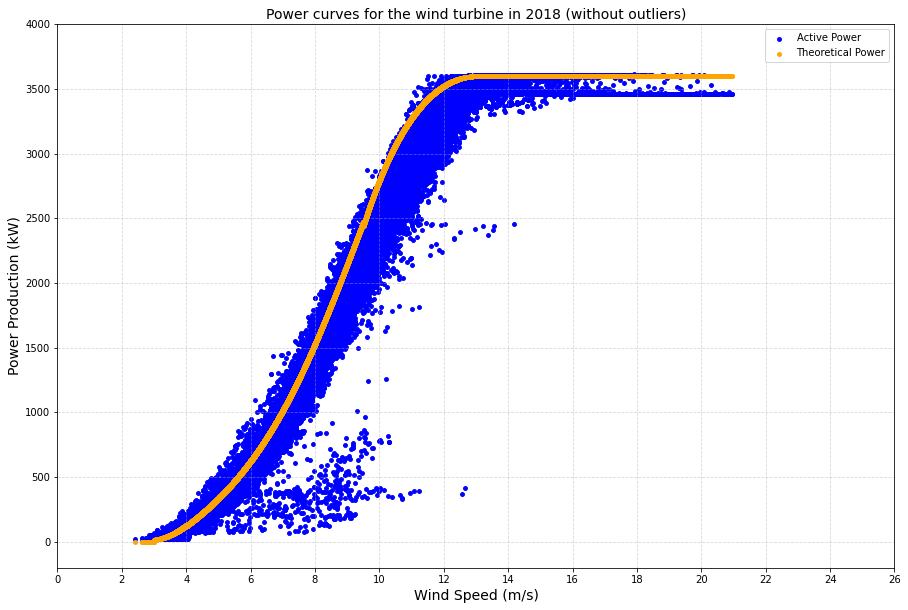

In [ ]:
# Plot power curves for the wind turbine

# Prepare the figure
plt.figure(figsize=(15, 10))

# Active power
plt.scatter(fact_table_filtered['wind_speed_mps'], fact_table_filtered['active_power_kw'], label='Active Power', color='blue', marker="o", s=15)

# Theoretical power
plt.scatter(fact_table_filtered['wind_speed_mps'], fact_table_filtered['theoretical_power_kwh'], label='Theoretical Power', color='orange', marker="o", s=15)

# Display legend
plt.legend()

# Label the x and y axes
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power Production (kW)', fontsize=14)
plt.title('Power curves for the wind turbine in 2018 (without outliers)', fontsize=14)

# Explicitly set the x-axis limits
xmin = 0  # Specify the lower limit
xmax = 26  # Specify the upper limit
x_step = 2  # Specify the step
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10)  # Set step and font size of x-axis ticks

# Set the y-axis limits and step
ymin = 0  # Specify the lower limit
ymax = 4000  # Specify the upper limit
y_step = 500  # Specify the step
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10)  # Set step and font size of y-axis ticks
plt.ylim(ymin-200, ymax)

# Add grids to the graph
plt.grid(True, linestyle='--', alpha=0.5)

# Display the graph
plt.show()

From this plot, we can see that the active power values that were not filtered out in the data manipulation are much closer to the theoretical power values.

This process is crucial in analysis because outliers can significantly skew results and mislead interpretations. By identifying and removing outliers, we ensure that the data more accurately reflects typical conditions, leading to more reliable and valid insights. This will certainly enhance the quality of our queries, statistical analyses, and visualizations, supporting accurate conclusions based on the data.

In [ ]:
# Convert the Pandas DataFrames to Spark DataFrames
fact_table_filtered_spark = spark.createDataFrame(fact_table_filtered)

# Save the Time dimension to a Delta table
dim_time.write.format("delta").mode("overwrite").save("/mnt/delta/dim_time")

# Save the Meteorology dimension to a Delta table
dim_meteorology.write.format("delta").mode("overwrite").save("/mnt/delta/dim_meteorology")

# Overwrite the original fact table with the filtered data
fact_table_filtered_spark.write.format("delta").mode("overwrite").save("/mnt/delta/fact_energy_production")

Let's check the schema for all dimensions as well as the updated fact table, separately.

In [ ]:
# Read and print the schema for dim_time
dim_time_check = spark.read.format("delta").load("/mnt/delta/dim_time")
dim_time_check.printSchema()


root
 |-- date_time_id: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- weekend: integer (nullable = true)



In [ ]:
# Read and print the schema for dim_meteorology
dim_meteorology_check = spark.read.format("delta").load("/mnt/delta/dim_meteorology")
dim_meteorology_check.printSchema()

root
 |-- date_time_id: timestamp (nullable = true)
 |-- wind_speed_mps: double (nullable = true)
 |-- wind_direction_deg: double (nullable = true)



In [ ]:
# Read and print the schema for fact_energy_production
fact_energy_production_check = spark.read.format("delta").load("/mnt/delta/fact_energy_production")
fact_energy_production_check.printSchema()

root
 |-- date_time_id: timestamp (nullable = true)
 |-- active_power_kw: double (nullable = true)
 |-- theoretical_power_kwh: double (nullable = true)
 |-- wind_speed_mps: double (nullable = true)
 |-- wind_direction_deg: double (nullable = true)



We can see that everything was correctly loaded into the Delta Tables. Now let's display the Fact Table DataFrame using Databricks built-in visualization.

In [ ]:
# Display the DataFrame
fact_energy_production_check.show(10)

+-------------------+----------------+---------------------+----------------+------------------+
|       date_time_id| active_power_kw|theoretical_power_kwh|  wind_speed_mps|wind_direction_deg|
+-------------------+----------------+---------------------+----------------+------------------+
|2018-01-01 12:30:00|41.9472389221191|     29.2869556318446|3.25396800041198|   233.06590270996|
|2018-01-03 17:10:00|65.9879074096679|      93.007188111359|3.80129408836364|  221.525894165039|
|2018-01-03 17:30:00|50.4220504760742|     74.4575206965673|3.67790603637695|  220.469299316406|
|2018-01-05 06:50:00|66.6415100097656|     96.1444767248149| 3.8206889629364|  39.2662200927734|
|2018-01-05 08:00:00|55.4453506469726|     82.7104874322431|3.73481607437133|  69.5399627685546|
|2018-01-05 08:10:00|22.7805309295654|     33.6245742525389|3.31020307540893|  74.8641128540039|
|2018-01-06 05:10:00|47.9093284606933|     126.101410575036|4.01667118072509|  133.604904174804|
|2018-01-06 15:20:00|63.053928

## 5.2. Updated Data Catalog

Since we modified the original DataFrame by removing outliers, we need to update the Data Catalog built and presented in Section 4.2. Here is the updated version of the Data Catalog. This statistical summary will provide us with the information we need.

In [ ]:
# Summary for updated Fact Table
fact_energy_production_check.describe().show()

+-------+------------------+---------------------+------------------+------------------+
|summary|   active_power_kw|theoretical_power_kwh|    wind_speed_mps|wind_direction_deg|
+-------+------------------+---------------------+------------------+------------------+
|  count|             38839|                38839|             38839|             38839|
|   mean|1744.5708227742728|   1892.1845646331544| 8.910827139605667|114.85969057872767|
| stddev| 1261.763468111167|   1297.7731078031716|3.6389001828132255| 85.33117229378811|
|    min|  20.0477409362792|                  0.0|  2.40486192703247|0.0156778804957867|
|    max|  3618.73291015625|               3600.0|  20.9692192077636|  359.997589111328|
+-------+------------------+---------------------+------------------+------------------+



**Data Lineage**

- **Source**: The dataset is obtained from the SCADA system of a wind turbine in a wind farm in Turkey during the year 2018.
- **Transformation**:
  - **Date/Time Conversion**: Converted the `Date/Time` column to a timestamp format.
  - **Dimension Creation**: Extracted relevant components to create Time and Meteorology dimensions.
  - **Fact Table Formation**: Combined key performance metrics and foreign keys to create the fact table.

**Summary**

This data catalog provides a comprehensive description of the fact and dimension tables, including the data types, expected ranges, and descriptions of each column. It also outlines the data lineage, ensuring transparency in the data transformation process.

**Fact Table: Energy Production**

| Column Name            | Data Type   | Description                                               |
|------------------------|-------------|-----------------------------------------------------------|
| date_time_id           | Timestamp   | Foreign key to the Time dimension, represents the date and time of the record. |
| active_power_kw        | Double      | Actual power (kW) produced by the wind turbine.                |
| theoretical_power_kwh  | Double      | Theoretical power (kWh) the turbine should produce at a given wind speed, according to the manufacturer. |
| wind_speed_mps          | Double      | Wind speed (m/s) at the hub height of the wind turbine.         |
| wind_direction_deg     | Double      | Wind direction (º) at the hub height of the wind turbine.     |

**Dimension Table: Time**

| Column Name    | Data Type | Description                                               |
|----------------|-----------|-----------------------------------------------------------|
| date_time_id   | Timestamp | Primary key, represents the date and time of the record.  |
| year           | Integer   | Year extracted from the date_time_id.                     |
| month          | Integer   | Month extracted from the date_time_id.                    |
| day            | Integer   | Day of the month extracted from the date_time_id.         |
| hour           | Integer   | Hour extracted from the date_time_id.                     |
| day_of_week    | Integer   | Day of the week extracted from the date_time_id (1=Monday, 7=Sunday). |
| weekend        | Integer   | Indicates if the day is a weekend (1 for Saturday and Sunday, 0 otherwise). |

**Dimension Table: Meteorology**

| Column Name            | Data Type   | Description                                               |
|------------------------|-------------|-----------------------------------------------------------|
| date_time_id           | Timestamp   | Foreign key to the Time dimension, represents the date and time of the record. |
| wind_speed_mps          | Double      | Wind speed at the hub height of the wind turbine.         |
| wind_direction_deg     | Double      | Wind direction at the hub height of the wind turbine.     |

**Dimension Table: Operations**

| Column Name           | Data Type   | Description                                               |
|-----------------------|-------------|-----------------------------------------------------------|
| date_time_id          | Timestamp   | Foreign key to the Time dimension, represents the date and time of the record. |
| active_power_kw       | Double      | Actual power produced by the wind turbine.                |
| wind_speed_mps        | Double      | Wind speed at the hub height of the wind turbine.         |
| is_outlier            | Boolean     | Indicates whether the record is an outlier (True for outliers, False otherwise). |

**Data Ranges and Expected Values**

**Fact Table: Energy Production**

| Column Name            | Min Value | Max Value |
|------------------------|-----------|-----------|
| active_power_kw        | 20.05         | 3618.73      |
| theoretical_power_kwh  | 0         | 3600     |
| wind_speed_mps          | 2.40         | 20.97      |
| wind_direction_deg     | 0.02         | 359.98       |

**Dimension Table: Time**

| Column Name    | Min Value | Max Value |
|----------------|-----------|-----------|
| year           | 2018      | 2018      |
| month          | 1         | 12        |
| day            | 1         | 31        |
| hour           | 0         | 23        |
| day_of_week    | 1         | 7         |
| weekend        | 0         | 1         |

**Dimension Table: Meteorology**

| Column Name            | Min Value | Max Value |
|------------------------|-----------|-----------|
| wind_speed_mps          | 2.40         | 20.97       |
| wind_direction_deg     | 0.02         | 359.99       |

## 5.3. Solving the Problem by Using SQL Queries

Before starting SQL Queries, we need to load our Delta tables into Spark DataFrames.

In [ ]:
dim_time = spark.read.format("delta").load("/mnt/delta/dim_time")
dim_meteorology = spark.read.format("delta").load("/mnt/delta/dim_meteorology")
fact_energy_production = spark.read.format("delta").load("/mnt/delta/fact_energy_production")

Now let's register these DataFrames as SQL temporary views. Once registered as views, we can run SQL queries directly in SQL cells within this Databricks notebook. This will simplify our workflow, especially when performing complex queries or aggregations.


In [ ]:
# Register the DataFrames as temporary views
dim_time.createOrReplaceTempView("dim_time")
dim_meteorology.createOrReplaceTempView("dim_meteorology")
fact_energy_production.createOrReplaceTempView("fact_energy_production")

At this point, it is important to check for duplicates that might have been intruduced during the data ingestion and/or transformation steps.

In [ ]:
# Identify duplicates across all columns
duplicates = fact_energy_production.groupBy(fact_energy_production.columns).count().filter("count > 1")

# Sum the counts of duplicate rows
total_duplicates = duplicates.agg(sum("count")).collect()[0][0] - duplicates.count()
print(f"Total number of duplicate rows: {total_duplicates}")

Total number of duplicate rows: 849


Once the duplicates were identified, we will remove them across all columns and save the de-duplicated data back into Delta Lake.

In [ ]:
# Remove duplicates across all columns
fact_energy_production_deduped = fact_energy_production.dropDuplicates()

# Save the de-duplicated DataFrame back to Delta Lake
fact_energy_production_deduped.write.format("delta").mode("overwrite").save("/mnt/delta/fact_energy_production")

Let's read the updated Delta table and verify that the duplicates have been removed.

In [ ]:
# Read the updated Delta table
fact_energy_production_updated = spark.read.format("delta").load("/mnt/delta/fact_energy_production")

# Check for duplicates again to confirm they have been removed
duplicates = fact_energy_production_updated.groupBy(fact_energy_production.columns).count().filter("count > 1")

# Sum the counts of duplicate rows, handling the case when there are no duplicates
duplicate_count_df = duplicates.agg(sum("count"))
duplicate_count = duplicate_count_df.collect()[0][0]

# If there are no duplicates, duplicate_count will be None, set it to 0 in that case
total_duplicates = duplicate_count - duplicates.count() if duplicate_count is not None else 0
print(f"Total number of duplicate rows after cleaning: {total_duplicates}")


Total number of duplicate rows after cleaning: 0


Now we can start addressing the questions that were established at the beginning of the project. Let's revisit these questions here:
1. What is the total energy production of the wind turbine in 2018?
2. What is the average energy production of the wind turbine per month?
3. What is the correlation between wind speed and energy production?
4. What is the difference between actual energy production and the theoretical power provided by the manufacturer?
5. How does wind direction affect energy production?
6. What are the patterns of energy production throughout the day?

We'll address them one by one in the following sections. Since we only have data for 2018, all the question and queries will be specified for this particular year.


### 5.3.1. Question 1

What is the total energy production of the wind turbine in 2018?

In [ ]:
%sql
-- Total energy production of the wind turbine in 2018
SELECT SUM(active_power_kw) AS total_energy_production
FROM fact_energy_production

total_energy_production
6.490206540472412E7


According to the query above, the energy production in 2018 was ~64,902,065kW (64.9GW).

### 5.3.2. Question 2

What is the average energy production of the wind turbine per month?
Not only we can query the average energy production, but also we can assess the variability of energy production throughout the year by calculating the standard deviation and the range of energy production for each month. Here is the SQL query to get these statistics:

In [ ]:
%sql
SELECT
MONTH(date_time_id) AS month,
AVG(active_power_kw) AS avg_energy_production,
STDDEV(active_power_kw) AS stddev_energy_production,
MAX(active_power_kw) - MIN(active_power_kw) AS range_energy_production
FROM
fact_energy_production
GROUP BY
MONTH(date_time_id)
ORDER BY
month


month,avg_energy_production,stddev_energy_production,range_energy_production
1,2008.6387633570034,1323.7507008408354,3584.0086555480957
2,2021.5608512883787,1277.154940124357,3584.20707321167
3,2368.718069472175,1269.7037511985607,3584.2224864959667
4,1357.8345141164539,1274.7763755795645,3584.6180667877197
5,1163.2776302613536,961.1734264967394,3583.9195709228516
6,1340.435960803041,1067.4248844852818,3598.6851692199707
7,699.4999893953682,642.50502238188,3433.467969894404
8,2078.600892878467,1126.3081797959887,3584.037919998164
9,1728.0188613388755,1291.4770321812614,3584.421808242798
10,1622.0803590215075,1122.8452392061367,3584.12606048584


The average energy production (in kW) of the wind turbine per month is show in the above table. Here is a bar graph with error bars to show the average energy production for each month and represent the standard deviation:

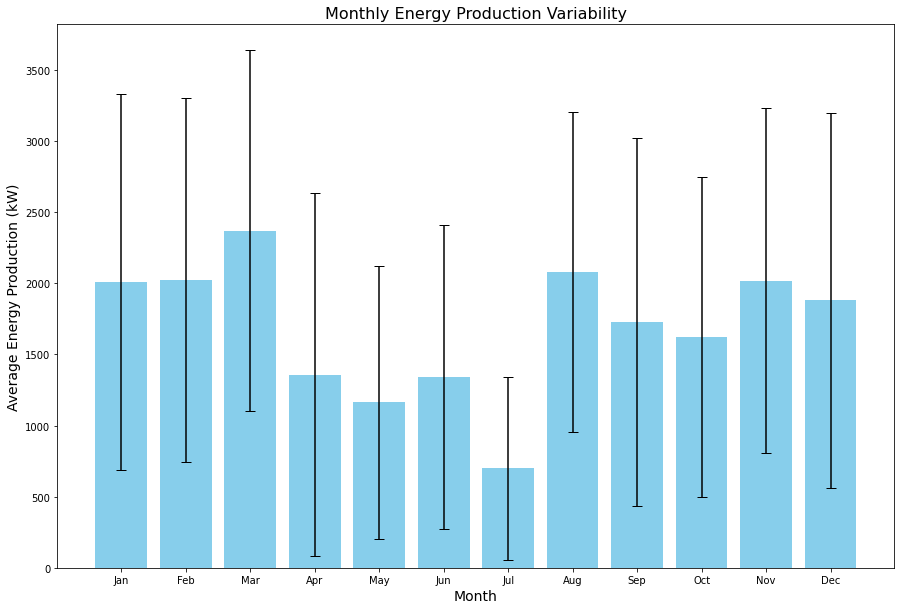

In [ ]:
# Building the DataFrame
df = spark.sql("""
SELECT
MONTH(date_time_id) AS month,
AVG(active_power_kw) AS avg_energy_production,
STDDEV(active_power_kw) AS stddev_energy_production
FROM
fact_energy_production
GROUP BY
MONTH(date_time_id)
ORDER BY month
""").toPandas()

# Plotting the bar graph with error bars
plt.figure(figsize=(15, 10))
plt.bar(df['month'], df['avg_energy_production'], yerr=df['stddev_energy_production'], capsize=5, color='skyblue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Energy Production (kW)', fontsize=14)
plt.title('Monthly Energy Production Variability', fontsize=16)
plt.xticks(df['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


From the graph, it is evident that March has the highest average energy production, indicating optimal wind conditions or turbine performance during this month. On the other hand, July shows the lowest energy production, suggesting less favorable wind conditions or other factors affecting the turbine's efficiency. Understanding these trends is crucial for optimizing energy production and planning maintenance activities.

The significant variations in the error bars indicate high variability in the energy production within each month. This suggests that the energy production values for that month are widely spread out from the mean. Here are some implications:
* Operational Instability: high variability might indicate operational instability or inconsistencies in the wind turbine's performance.
* Environmental Factors: it could also reflect the impact of varying environmental conditions, such as changes in wind speed and direction, which affect energy production.

### 5.3.3. Question 3

What is the correlation between wind speed and energy production?

In [ ]:
%sql
-- Calculate the correlation between wind speed and energy production
SELECT corr(wind_speed_mps, active_power_kw) AS correlation
FROM fact_energy_production;

correlation
0.9424981312496632


The correlation between wind speed (`wind_speed_mps`) and energy production (`active_power_kw`) is 0.94, indicating a very strong positive linear relationship. This high correlation suggests that as the wind speed increases, the energy production of the wind turbine also increases in a highly predictable manner. This is expected for wind turbines, as higher wind speeds typically result in higher energy output, up to the turbine's maximum capacity. This strong positive correlation implies that wind speed is a key factor in determining the energy production, highlighting the importance of wind conditions in the performance and efficiency of wind turbines.

### 5.3.4. Question 4

What is the difference between actual energy production and the theoretical power provided by the manufacturer?

In [ ]:
%sql
-- Calculate the difference between actual energy production and the theoretical power curve
SELECT
AVG(active_power_kw) AS avg_actual_power_kw,
AVG(theoretical_power_kwh) AS avg_theoretical_power_kw,
(AVG(active_power_kw) - AVG(theoretical_power_kwh)) AS avg_difference_kw
FROM fact_energy_production;



avg_actual_power_kw,avg_theoretical_power_kw,avg_difference_kw
1708.3986681948966,1855.768047022601,-147.3693788277044


The difference between average energy production and average theoretical power provided by the manufacturer was around -147kW. Although this difference is relatively small, it can still indicate some gaps in performance. This discrepancy may arise due to various factors such as mechanical losses, aerodynamic inefficiencies, and suboptimal wind conditions. Understanding and addressing these gaps can help improve the turbine's operational efficiency and maximise energy output, ensuring that it performs closer to its theoretical potential.

### 5.3.5. Question 5

How does wind direction affect energy production?

To understand how wind direction affects energy production, we can calculate the average energy production for different ranges of wind directions. Here is a SQL query to achieve this:

In [ ]:
%sql
SELECT
FLOOR(wind_direction_deg / 30) * 30 AS wind_direction_range,
AVG(active_power_kw) AS avg_energy_production
FROM
fact_energy_production
GROUP BY
FLOOR(wind_direction_deg / 30) * 30
ORDER BY
wind_direction_range;


wind_direction_range,avg_energy_production
0,1283.3740428561564
30,1670.8692824045818
60,1730.3625643265405
90,417.55431117424104
120,766.092624032573
150,1775.4991995631035
180,2421.707505886696
210,1884.491586281012
240,912.1448563308879
270,743.8351381065834


This query groups the data by 30-degree ranges of wind direction and calculates the average energy production for each range. From this table we can see that from 150 to 210 degrees is the range associated with higher energy production. Let's have a look at the polar graph by grouping the data by 5-degree ranges.

In [ ]:
# Creating a spark DataFrame to plot the polar graph
wind_direction_energy_df = spark.sql("""
SELECT
FLOOR(wind_direction_deg / 5) * 5 AS wind_direction_range,
AVG(active_power_kw) AS avg_energy_production
FROM
fact_energy_production
GROUP BY
FLOOR(wind_direction_deg / 5) * 5
ORDER BY
wind_direction_range
""").toPandas()


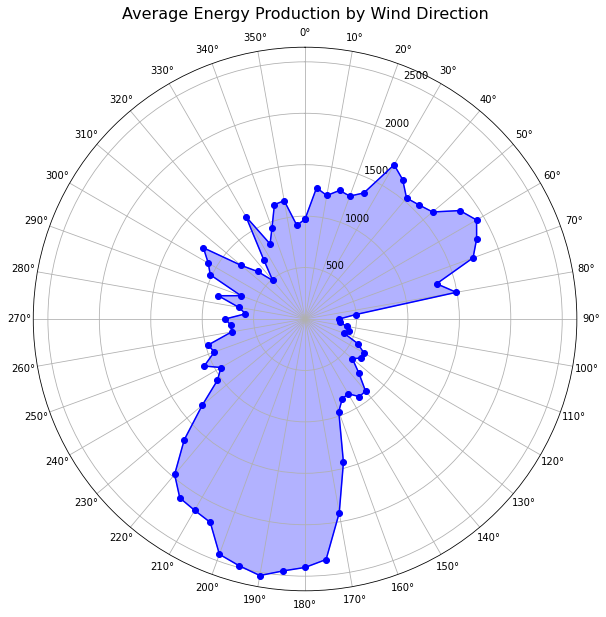

In [ ]:
# Prepare the data
angles = np.deg2rad(wind_direction_energy_df['wind_direction_range'].values)
avg_energy = wind_direction_energy_df['avg_energy_production'].values

# Since the polar plot is circular, we need to complete the loop
angles = np.append(angles, angles[0])
avg_energy = np.append(avg_energy, avg_energy[0])

# Create the polar plot
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, polar=True)

# Plot data
ax.plot(angles, avg_energy, marker='o', linestyle='-', color='b')
ax.fill(angles, avg_energy, color='b', alpha=0.3)

# Add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(np.deg2rad(np.arange(0, 360, 10)))
ax.set_xticklabels(['0°', '10°', '20°', '30°', '40°', '50°', '60°', '70°', '80°', '90°', '100°', '110°', '120°', '130°', '140°', '150°', '160°', '170°', '180°', '190°', '200°', '210°', '220°', '230°', '240°', '250°', '260°', '270°', '280°', '290°', '300°', '310°', '320°', '330°', '340°', '350°'])
ax.set_title('Average Energy Production by Wind Direction', fontsize=16, va='bottom')

# Show the plot
plt.show()


This graph effectively illustrates how different wind directions influence energy production, refining our observation from the table generated by the query. Here we can clearly identify that directions in the range 170-220 degrees yield the highest energy production and directions with ranges between 80-160 and 240-360 degrees presented the lower power output. Here we have a few implications of such information:
* Optimal wind directions: directions between 170-220 degrees yield the highest energy production, indicating the turbine operates most efficiently with wind from these directions.

* Suboptimal wind directions: directions between 80-160 and 240-360 degrees result in lower energy production, suggesting potential obstructions or misalignment in these directions.

* Turbine efficiency and site selection: understanding these patterns helps in optimizing turbine orientation, planning maintenance, and selecting new sites to maximize energy output.

* Performance monitoring: identifying high and low production directions aids in focused performance improvements and design optimisations.

### 5.3.6. Question 6

What are the patterns of energy production throughout the day?
To answer this question, we can analyse the average energy production at different hours. This analysis helps to reveal if there are specific times during the day when the wind turbine generates more or less energy. This query will provide the average energy production for each hour of the day.

In [ ]:
%sql
SELECT
hour(date_time_id) AS hour_of_day,
AVG(active_power_kw) AS avg_energy_production
FROM
fact_energy_production
GROUP BY
hour(date_time_id)
ORDER BY
hour_of_day


hour_of_day,avg_energy_production
0,1789.3507200677566
1,1775.995340359248
2,1824.6873717952092
3,1768.536618358818
4,1818.4666047038875
5,1756.024672857325
6,1697.0419852391203
7,1723.3702452793707
8,1606.3338325660122
9,1539.5373763438206


To visualize the patterns of energy production throughout the day, we can plot a line graph.

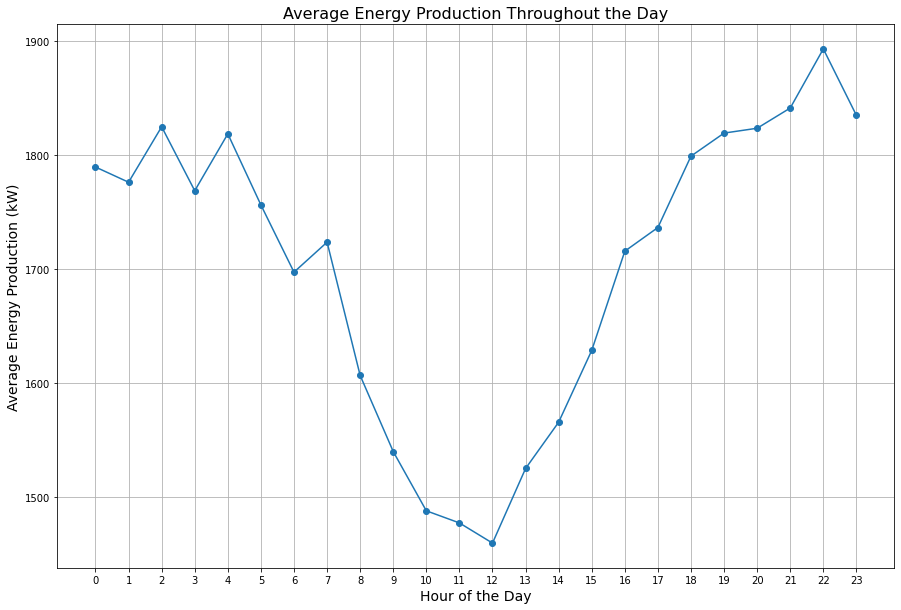

In [ ]:
# Execute the query and convert the result to a Pandas DataFrame
hourly_energy_df = spark.sql("""
SELECT
hour(date_time_id) AS hour_of_day,
AVG(active_power_kw) AS avg_energy_production
FROM
fact_energy_production
GROUP BY
hour(date_time_id)
ORDER BY
hour_of_day
""").toPandas()

# Plot the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(hourly_energy_df['hour_of_day'], hourly_energy_df['avg_energy_production'], marker='o', linestyle='-')
plt.title('Average Energy Production Throughout the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Energy Production (kW)', fontsize=14)
plt.xticks(range(0, 24))  # Set x-axis labels for each hour
plt.grid()
plt.show()

From this graph, we can identify the peak (at 22h) and the trough (at 12h) in the energy production for this wind turbine, helping us understand how energy output fluctuates over a 24-hour period. This insight can be crucial for optimizing energy storage and distribution strategies, as well as for planning maintenance activities during lower production times.

# 6. Conclusions and Self-Assessment

From this project, we can draw the following conclusios:

1. **Peak energy production times**: analysis of energy production throughout the day revealed peak production times around noon and the lowest production around 10 PM. This insight can help optimize the scheduling of maintenance activities and better align energy production forecasts.

2. **Seasonal variations**: The data showed significant seasonal variations in energy production, with March having the highest production and July the lowest. This finding suggests that energy output is strongly influenced by seasonal wind patterns, which is crucial for planning and managing energy resources throughout the year.

3. **Correlation between wind speed and energy production**: a high correlation coefficient of 0.94 was found between wind speed and energy production, indicating that wind speed is a strong predictor of energy output. This reinforces the importance of accurate wind speed forecasting for reliable energy production estimates.

4. **Wind direction influence**: the analysis showed that wind directions between 170-220 degrees are associated with the highest energy production, while directions between 80-160 and 240-360 degrees result in lower outputs. This information can be used to optimize the positioning and alignment of wind turbines for maximum efficiency.

5. **Handling outliers**: the process of identifying and removing outliers was crucial for ensuring the accuracy of the analysis. By filtering out anomalous data points, the study maintained data integrity and produced more reliable insights.

6. **Comparison of actual vs. theoretical energy production**: the difference between actual energy production and the theoretical power curve provided by the manufacturer was around -147 kW. This small discrepancy indicates that the wind turbine is performing close to its expected efficiency but highlights areas where performance could be improved.

7. **Data infrastructure and management**: the successful implementation of a Delta Lake for data storage and management facilitated efficient querying and analysis. The organized data structure ensured seamless access and manipulation of data, contributing to the overall success of the project.

8. **Data persistance**: data persistence was ensured by using Delta Lake, providing ACID transactions and comprehensive traceability. The data remained reliable, consistent, and efficiently accessible for analysis.

All the analysis objectives were successfully achieved, as all questions were answered based on the data. This was only possible because the data was properly processed, leading to targeted and accurate queries.

The notebook was built to facilitate readability and understanding for external users. To this end, data processing and manipulation operations, the data pipeline, the creation and updates of the Delta Lake, the Data Catalog, and other content were built sequentially within this single file.